# Homework 4

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction  import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

**Data preparation**
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [10]:
df = pd.read_csv('./course_lead_scoring.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [11]:
categorical_features = [i for i in df.columns if df[i].dtype == 'object']
numerical_features = [i for i in df.columns if df[i].dtype != 'object' and i != 'converted']

In [51]:
categorical_features + numerical_features

['lead_source',
 'industry',
 'employment_status',
 'location',
 'number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [12]:
# fill missing values
df[categorical_features] = df[categorical_features].fillna('NA')
df[numerical_features] = df[numerical_features].fillna(0)

In [98]:
# split data into training, validation, and testing

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


X_train = df_train[categorical_features + numerical_features]
X_val = df_val[categorical_features + numerical_features]
X_test = df_test[categorical_features + numerical_features]

y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

In [99]:
X_train.shape, X_val.shape, X_test.shape

((876, 8), (293, 8), (293, 8))

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

**which numerical variable has the highest AUC?**

In [100]:
feature_auc_list = []

# Iterate over each column (feature) in the training data
for feature in X_train[numerical_features].columns:
    # 1. Instantiate a simple model
    # A decision tree stump is a good choice for this
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    # 2. Fit the model using only the current feature
    # Note: Scikit-learn expects a 2D array, so we use [[]]
    model.fit(X_train[[feature]], y_train)
    
    # 3. Make predictions on the test set
    # We're interested in the probability of the positive class (class 1)
    y_pred_proba = model.predict_proba(X_test[[feature]])[:, 1]
    
    # 4. Calculate the ROC AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # 5. Store the feature name and its AUC score
    feature_auc_list.append({'feature': feature, 'roc_auc': auc_score})

# Convert the list of dictionaries to a pandas DataFrame
feature_auc_df = pd.DataFrame(feature_auc_list)

# Sort the DataFrame by ROC AUC in descending order
feature_auc_df_sorted = feature_auc_df.sort_values(by='roc_auc', ascending=False)

print("\n--- Feature Importance based on Univariate ROC AUC ---")
print(feature_auc_df_sorted)


--- Feature Importance based on Univariate ROC AUC ---
                    feature   roc_auc
0  number_of_courses_viewed  0.775370
2         interaction_count  0.700460
3                lead_score  0.599719
1             annual_income  0.501712


## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

>```python
>LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
>```

**What's the AUC of this model on the validation dataset? (round to 3 digits)**

In [101]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [102]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'
)

In [103]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

In [104]:
model_pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [107]:
y_pred_test = model_pipeline.predict(X_test)

round(roc_auc_score(y_test, y_pred_test), 3)

0.679

In [108]:
dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical_features + numerical_features].to_dict(orient='records')
X_train_dv = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [109]:
X_val_dv = dv.transform(X_val[categorical_features + numerical_features].to_dict(orient='records'))
y_pred_val = model.predict(X_val_dv)

round(roc_auc_score(y_val, y_pred_val), 3)

0.648

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [110]:
# Method 1: Using precision_recall_curve (recommended)
# This automatically calculates optimal thresholds
def plot_precision_recall_curve_auto(model, X_val, y_val):
    """Plot precision-recall curve using sklearn's precision_recall_curve"""
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]  # Probability of positive class
    
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    return precision, recall, thresholds

# Method 2: Manual calculation with custom thresholds (0 to 1, step 0.01)
def plot_precision_recall_manual(model, X_val, y_val):
    """Plot precision-recall curve with custom threshold range"""
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Define threshold range
    thresholds = np.arange(0.0, 1.01, 0.01)  # 0 to 1 with step 0.01
    
    precisions = []
    recalls = []
    
    print("Calculating precision and recall for each threshold...")
    
    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate precision and recall
        # Handle edge cases where no positive predictions exist
        if y_pred.sum() == 0:  # No positive predictions
            precision = 0.0
        else:
            precision = precision_score(y_val, y_pred, zero_division=0)
            
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # Main plot
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2, marker='o', markersize=2)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2, marker='s', markersize=2)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold (Step = 0.01)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Zoomed plot for better detail
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=1)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=1)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold (Detailed View)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0.2, 0.8])  # Focus on middle range
    plt.ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    return thresholds, precisions, recalls

# Method 3: Combined precision-recall curve and threshold analysis
def comprehensive_precision_recall_analysis(model, X_val, y_val):
    """Comprehensive analysis with both PR curve and threshold plots"""
    
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Calculate with sklearn function
    precision_auto, recall_auto, thresholds_auto = precision_recall_curve(y_val, y_prob)
    
    # Calculate with manual thresholds
    thresholds_manual = np.arange(0.0, 1.01, 0.01)
    precisions_manual = []
    recalls_manual = []
    
    for threshold in thresholds_manual:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        precisions_manual.append(precision)
        recalls_manual.append(recall)
    
    # Create comprehensive plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Precision-Recall Curve
    axes[0, 0].plot(recall_auto, precision_auto, 'g-', linewidth=2)
    axes[0, 0].set_xlabel('Recall')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].set_title('Precision-Recall Curve')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Precision vs Threshold
    axes[0, 1].plot(thresholds_manual, precisions_manual, 'b-', linewidth=2)
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision vs Threshold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Recall vs Threshold
    axes[1, 0].plot(thresholds_manual, recalls_manual, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Recall vs Threshold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Both Precision and Recall vs Threshold
    axes[1, 1].plot(thresholds_manual, precisions_manual, 'b-', label='Precision', linewidth=2)
    axes[1, 1].plot(thresholds_manual, recalls_manual, 'r-', label='Recall', linewidth=2)
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision and Recall vs Threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold (maximize F1-score)
    f1_scores = []
    for p, r in zip(precisions_manual, recalls_manual):
        if p + r == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * (p * r) / (p + r))
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds_manual[optimal_idx]
    optimal_precision = precisions_manual[optimal_idx]
    optimal_recall = recalls_manual[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    print(f"Optimal Threshold (max F1): {optimal_threshold:.2f}")
    print(f"Precision at optimal threshold: {optimal_precision:.3f}")
    print(f"Recall at optimal threshold: {optimal_recall:.3f}")
    print(f"F1-Score at optimal threshold: {optimal_f1:.3f}")
    
    return thresholds_manual, precisions_manual, recalls_manual

In [111]:
# Example usage: 
# Assuming you have a trained model and validation data

# Example: Simple precision-recall vs threshold plot
def simple_precision_recall_plot(model, X_val, y_val):
    """Simple function to plot precision and recall vs threshold"""
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Create threshold range from 0 to 1 with step 0.01
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    precisions = []
    recalls = []
    
    # Calculate precision and recall for each threshold
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate metrics (handle division by zero)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    return thresholds, precisions, recalls

# To use any of these functions, simply call:
# thresholds, precisions, recalls = simple_precision_recall_plot(your_model, X_val, y_val)
# or
# comprehensive_precision_recall_analysis(your_model, X_val, y_val)

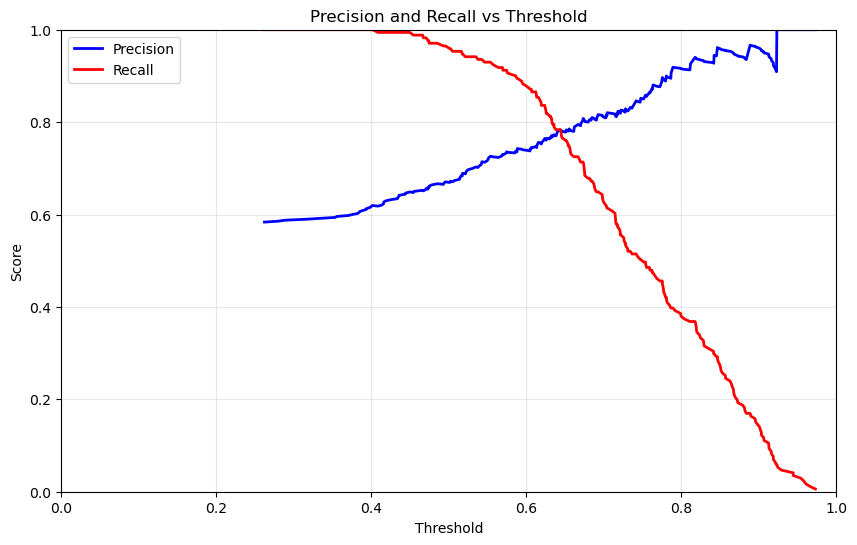

(array([0.58361775, 0.58561644, 0.58762887, 0.58965517, 0.5916955 ,
        0.59375   , 0.59581882, 0.5979021 , 0.6       , 0.60211268,
        0.60424028, 0.60638298, 0.60854093, 0.61071429, 0.61290323,
        0.61510791, 0.61732852, 0.61956522, 0.61818182, 0.62043796,
        0.62271062, 0.625     , 0.62730627, 0.62962963, 0.63197026,
        0.63432836, 0.63670412, 0.63909774, 0.64150943, 0.64393939,
        0.64638783, 0.64885496, 0.64750958, 0.65      , 0.65250965,
        0.65116279, 0.6536965 , 0.65625   , 0.65490196, 0.65748031,
        0.66007905, 0.65873016, 0.66135458, 0.664     , 0.66666667,
        0.66532258, 0.66801619, 0.67073171, 0.66938776, 0.67213115,
        0.67078189, 0.67355372, 0.67634855, 0.67916667, 0.68200837,
        0.68487395, 0.6835443 , 0.68644068, 0.6893617 , 0.68803419,
        0.69098712, 0.69396552, 0.6969697 , 0.7       , 0.70305677,
        0.70175439, 0.70484581, 0.7079646 , 0.71111111, 0.71428571,
        0.71300448, 0.71621622, 0.71945701, 0.72

In [112]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train_dv, y_train)

plot_precision_recall_curve_auto(model=model, X_val=X_val_dv, y_val=y_val)

Calculating precision and recall for each threshold...


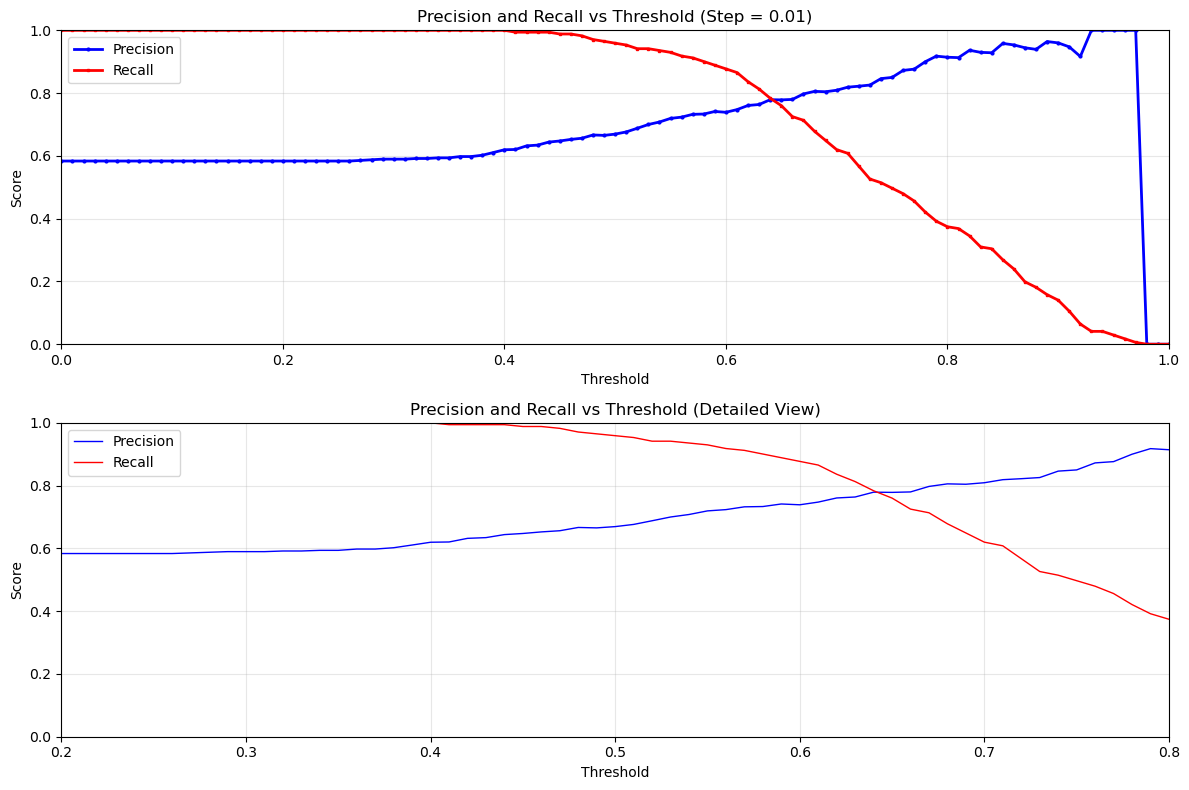

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 [0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.5836177474402731,
  0.

In [113]:
plot_precision_recall_manual(model=model, X_val=X_val_dv, y_val=y_val)

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both  
This is the formula for computing F1:

$$F1=2⋅ \frac{P⋅R}{P+R} $$


Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

**At which threshold F1 is maximal?**

In [114]:
def calculate_f1_scores_across_thresholds(model, X_val, y_val):
    """
    Calculate F1 scores for all thresholds from 0.0 to 1.0 with increment 0.01
    and find the threshold where F1 is maximal
    """
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Define threshold range from 0 to 1 with step 0.01
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    print("Calculating F1 scores for each threshold...")
    
    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate precision and recall
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        # Calculate F1 score using the formula: F1 = 2 * (P * R) / (P + R)
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Find the threshold with maximum F1 score
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    optimal_precision = precisions[max_f1_idx]
    optimal_recall = recalls[max_f1_idx]
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: F1 Score vs Threshold
    axes[0, 0].plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    axes[0, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
                       label=f'Max F1 at {optimal_threshold:.2f}')
    axes[0, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title(f'F1 Score vs Threshold\nMax F1: {max_f1_score:.3f} at threshold {optimal_threshold:.2f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 1])
    axes[0, 0].set_ylim([0, 1])
    
    # Plot 2: Precision, Recall, and F1 together
    axes[0, 1].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[0, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[0, 1].plot(thresholds, f1_scores, 'g-', label='F1 Score', linewidth=2)
    axes[0, 1].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7,
                       label=f'Optimal threshold: {optimal_threshold:.2f}')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Precision, Recall, and F1 Score vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].set_ylim([0, 1])
    
    # Plot 3: Zoomed F1 Score around optimal threshold
    zoom_range = 0.1  # Show ±0.1 around optimal threshold
    zoom_min = max(0, optimal_threshold - zoom_range)
    zoom_max = min(1, optimal_threshold + zoom_range)
    
    zoom_mask = (thresholds >= zoom_min) & (thresholds <= zoom_max)
    axes[1, 0].plot(thresholds[zoom_mask], np.array(f1_scores)[zoom_mask], 'g-', 
                    linewidth=2, marker='o', markersize=4)
    axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title(f'F1 Score (Zoomed)\nAround Optimal Threshold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Bar chart showing top 10 F1 scores
    top_10_indices = np.argsort(f1_scores)[-10:]
    top_10_thresholds = thresholds[top_10_indices]
    top_10_f1_scores = np.array(f1_scores)[top_10_indices]
    
    bars = axes[1, 1].bar(range(len(top_10_thresholds)), top_10_f1_scores, 
                          color=['red' if t == optimal_threshold else 'skyblue' for t in top_10_thresholds])
    axes[1, 1].set_xlabel('Rank (Best to 10th Best)')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_title('Top 10 F1 Scores')
    axes[1, 1].set_xticks(range(len(top_10_thresholds)))
    axes[1, 1].set_xticklabels([f'{t:.2f}' for t in top_10_thresholds], rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("F1 SCORE ANALYSIS RESULTS")
    print("="*60)
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    print(f"Precision at optimal threshold: {optimal_precision:.3f}")
    print(f"Recall at optimal threshold: {optimal_recall:.3f}")
    print(f"F1 Formula verification: 2*P*R/(P+R) = 2*{optimal_precision:.3f}*{optimal_recall:.3f}/({optimal_precision:.3f}+{optimal_recall:.3f}) = {max_f1_score:.3f}")
    
    # Show top 5 thresholds with highest F1 scores
    print("\nTop 5 thresholds with highest F1 scores:")
    print("-" * 40)
    top_5_indices = np.argsort(f1_scores)[-5:][::-1]  # Get top 5 in descending order
    for i, idx in enumerate(top_5_indices, 1):
        print(f"{i}. Threshold: {thresholds[idx]:.2f}, F1: {f1_scores[idx]:.3f}, "
              f"Precision: {precisions[idx]:.3f}, Recall: {recalls[idx]:.3f}")
    
    return thresholds, f1_scores, optimal_threshold, max_f1_score

# Simple version for quick usage
def find_optimal_f1_threshold(model, X_val, y_val):
    """
    Simple function to find optimal F1 threshold and create basic plot
    """
    y_prob = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    
    # Find optimal threshold
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.8, 
                label=f'Max F1: {max_f1_score:.3f} at {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    
    return optimal_threshold, max_f1_score

Calculating F1 scores for each threshold...


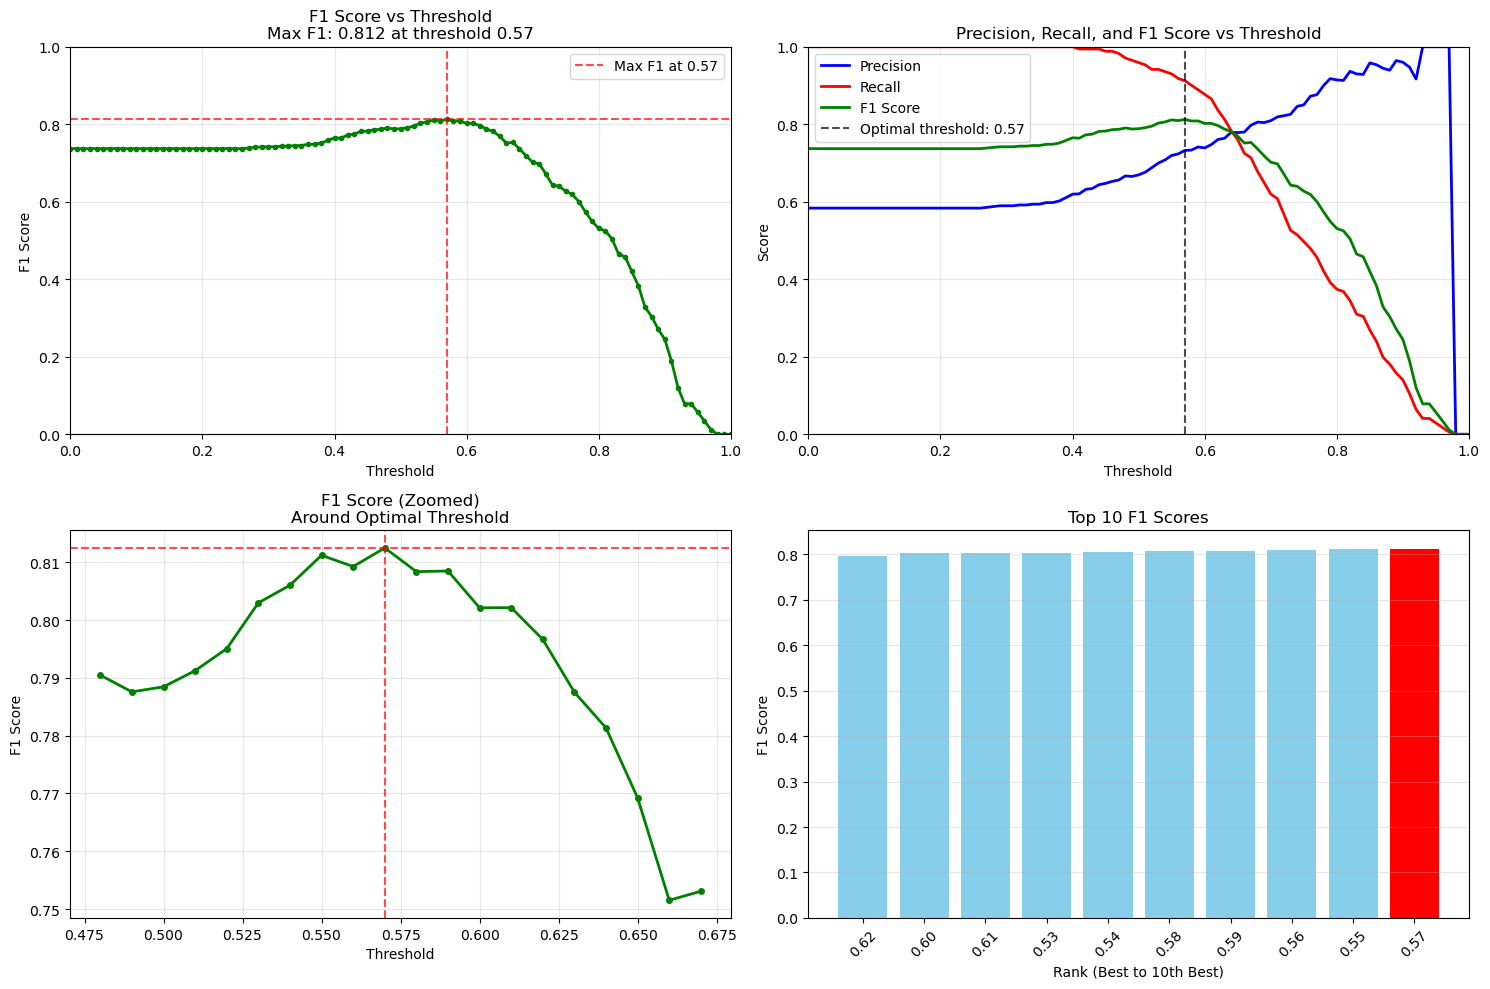


F1 SCORE ANALYSIS RESULTS
Optimal Threshold: 0.57
Maximum F1 Score: 0.812
Precision at optimal threshold: 0.732
Recall at optimal threshold: 0.912
F1 Formula verification: 2*P*R/(P+R) = 2*0.732*0.912/(0.732+0.912) = 0.812

Top 5 thresholds with highest F1 scores:
----------------------------------------
1. Threshold: 0.57, F1: 0.812, Precision: 0.732, Recall: 0.912
2. Threshold: 0.55, F1: 0.811, Precision: 0.719, Recall: 0.930
3. Threshold: 0.56, F1: 0.809, Precision: 0.724, Recall: 0.918
4. Threshold: 0.59, F1: 0.809, Precision: 0.741, Recall: 0.889
5. Threshold: 0.58, F1: 0.808, Precision: 0.733, Recall: 0.901

🎯 ANSWER TO QUESTION 4:
F1 score is maximal at threshold: 0.57
Maximum F1 score: 0.812


In [115]:
# Answer Question 4: Find optimal F1 threshold
# Use the comprehensive analysis
thresholds, f1_scores, optimal_threshold, max_f1_score = calculate_f1_scores_across_thresholds(model, X_val_dv, y_val)

print(f"\n🎯 ANSWER TO QUESTION 4:")
print(f"F1 score is maximal at threshold: {optimal_threshold:.2f}")
print(f"Maximum F1 score: {max_f1_score:.3f}")

## What is a Threshold? 🤔

**Threshold** is a decision boundary that determines how we convert predicted probabilities into final binary predictions.

### How Logistic Regression Works:

1. **Logistic Regression Output**: The model outputs **probabilities** between 0 and 1
   - Example: 0.73 means 73% probability that the sample belongs to the positive class
   - Example: 0.23 means 23% probability that the sample belongs to the positive class

2. **The Threshold Decision**: We need to convert these probabilities into binary predictions (0 or 1)
   - **If probability ≥ threshold → Predict class 1 (positive)**
   - **If probability < threshold → Predict class 0 (negative)**

### Default Threshold = 0.5

By default, most ML libraries use **threshold = 0.5**:
- Probability ≥ 0.5 → Predict 1 (converted = True)
- Probability < 0.5 → Predict 0 (converted = False)

### Why Adjust the Threshold?

Different thresholds lead to different trade-offs:

| Threshold | Effect | Use Case |
|-----------|--------|----------|
| **Low (0.1)** | More predictions as positive | When you want to catch all possible positives (high recall) |
| **Default (0.5)** | Balanced predictions | General purpose |
| **High (0.9)** | Fewer predictions as positive | When you want to be very sure (high precision) |

### Real-World Example: Lead Scoring

In your homework (lead conversion prediction):

- **Threshold = 0.3**: "If there's 30% chance they'll convert, let's call them"
  - Result: Call more leads (high recall), but many won't convert (low precision)
  
- **Threshold = 0.7**: "Only call if there's 70% chance they'll convert"
  - Result: Call fewer leads (low recall), but most will convert (high precision)

### Business Impact:

**Marketing Team Perspective:**
- Low threshold → More leads to follow up → Higher costs but don't miss opportunities
- High threshold → Fewer leads to follow up → Lower costs but might miss some conversions

**The threshold is essentially asking: "How confident should the model be before we take action?"**

In [116]:
# Let's demonstrate how threshold works with a simple example
print("THRESHOLD DEMONSTRATION")
print("=" * 50)

# Get prediction probabilities from our model
y_prob = model.predict_proba(X_val_dv)[:, 1]

print(f"First 10 prediction probabilities: {y_prob[:10].round(3)}")
print(f"Actual labels for first 10 samples: {y_val.iloc[:10].values}")

print("\nHow different thresholds affect predictions:")
print("-" * 50)

# Test different thresholds
test_thresholds = [0.2, 0.5, 0.8]

for threshold in test_thresholds:
    # Apply threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Count predictions
    positive_predictions = sum(y_pred)
    total_predictions = len(y_pred)
    
    print(f"\nThreshold = {threshold}")
    print(f"  Positive predictions: {positive_predictions}/{total_predictions} ({positive_predictions/total_predictions*100:.1f}%)")
    print(f"  First 10 predictions: {y_pred[:10]}")
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")

print("\n" + "=" * 50)
print("KEY INSIGHT:")
print("Lower threshold → More positive predictions → Higher Recall, Lower Precision")
print("Higher threshold → Fewer positive predictions → Lower Recall, Higher Precision")

THRESHOLD DEMONSTRATION
First 10 prediction probabilities: [0.575 0.471 0.619 0.614 0.617 0.675 0.847 0.382 0.557 0.912]
Actual labels for first 10 samples: [1 1 1 0 1 1 1 0 1 1]

How different thresholds affect predictions:
--------------------------------------------------

Threshold = 0.2
  Positive predictions: 293/293 (100.0%)
  First 10 predictions: [1 1 1 1 1 1 1 1 1 1]
  Precision: 0.584
  Recall: 1.000

Threshold = 0.5
  Positive predictions: 245/293 (83.6%)
  First 10 predictions: [1 0 1 1 1 1 1 0 1 1]
  Precision: 0.669
  Recall: 0.959

Threshold = 0.8
  Positive predictions: 70/293 (23.9%)
  First 10 predictions: [0 0 0 0 0 0 1 0 0 1]
  Precision: 0.914
  Recall: 0.374

KEY INSIGHT:
Lower threshold → More positive predictions → Higher Recall, Lower Precision
Higher threshold → Fewer positive predictions → Lower Recall, Higher Precision


## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

> ```python
> KFold(n_splits=5, shuffle=True, random_state=1)
> ```

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation  

How large is standard deviation of the scores across different folds?


In [117]:
# Combine X_train and X_val for cross-validation as per the prompt's context
# The prompt asks to iterate over folds of df_full_train, which is essentially the combined training and validation data before the final split
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

print("Performing 5-Fold Cross-Validation:")
# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X_full_train), 1):
    print(f"\n--- Fold {fold} ---")

    # Split data for the current fold
    X_train_fold, X_val_fold = X_full_train.iloc[train_index], X_full_train.iloc[val_index]
    y_train_fold, y_val_fold = y_full_train.iloc[train_index], y_full_train.iloc[val_index]

    # Transform data for the current fold using DictVectorizer
    # Re-initialize DictVectorizer for each fold to avoid data leakage
    dv_fold = DictVectorizer(sparse=False)

    train_dict_fold = X_train_fold[categorical_features + numerical_features].to_dict(orient='records')
    X_train_fold_dv = dv_fold.fit_transform(train_dict_fold)

    val_dict_fold = X_val_fold[categorical_features + numerical_features].to_dict(orient='records')
    X_val_fold_dv = dv_fold.transform(val_dict_fold)

    # Initialize and train the Logistic Regression model for the current fold
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold_dv, y_train_fold)

    # Predict probabilities on the validation data for the current fold
    y_pred_prob_val_fold = model_fold.predict_proba(X_val_fold_dv)[:, 1]

    # Calculate AUC for the current fold
    auc_fold = roc_auc_score(y_val_fold, y_pred_prob_val_fold)
    print(f"AUC for Fold {fold}: {auc_fold:.4f}")

    # Append the AUC score to the list
    auc_scores.append(auc_fold)

# Calculate the mean and standard deviation of the AUC scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("\n" + "="*30)
print("CROSS-VALIDATION RESULTS")
print("="*30)
print(f"Mean AUC across {kf.n_splits} folds: {mean_auc:.4f}")
print(f"Standard Deviation of AUC across {kf.n_splits} folds: {std_auc:.4f}")

print(f"\n🎯 ANSWER TO QUESTION 5:")
print(f"Standard deviation of the scores across different folds: {std_auc:.3f}")

Performing 5-Fold Cross-Validation:

--- Fold 1 ---
AUC for Fold 1: 0.8180

--- Fold 2 ---
AUC for Fold 2: 0.8035

--- Fold 3 ---
AUC for Fold 3: 0.8425

--- Fold 4 ---
AUC for Fold 4: 0.8024

--- Fold 5 ---
AUC for Fold 5: 0.8448

CROSS-VALIDATION RESULTS
Mean AUC across 5 folds: 0.8222
Standard Deviation of AUC across 5 folds: 0.0183

🎯 ANSWER TO QUESTION 5:
Standard deviation of the scores across different folds: 0.018


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?


HYPERPARAMETER TUNING: Testing different C values

Testing C = 1e-06
------------------------------
  Fold 1: AUC = 0.5804
  Fold 2: AUC = 0.5751
  Fold 3: AUC = 0.5199
  Fold 4: AUC = 0.6251
  Fold 5: AUC = 0.5070
  Mean AUC: 0.561
  Std AUC: 0.043

Testing C = 0.001
------------------------------
  Fold 1: AUC = 0.8591
  Fold 2: AUC = 0.8448
  Fold 3: AUC = 0.8877
  Fold 4: AUC = 0.8614
  Fold 5: AUC = 0.8798
  Mean AUC: 0.867
  Std AUC: 0.015

Testing C = 1
------------------------------
  Fold 1: AUC = 0.8180
  Fold 2: AUC = 0.8035
  Fold 3: AUC = 0.8425
  Fold 4: AUC = 0.8024
  Fold 5: AUC = 0.8448
  Mean AUC: 0.822
  Std AUC: 0.018

HYPERPARAMETER TUNING RESULTS
C Value      Mean AUC   Std AUC    All Fold Scores
-------------------------------------------------------
1e-06        0.561      0.043      ['0.580', '0.575', '0.520', '0.625', '0.507']
0.001        0.867      0.015      ['0.859', '0.845', '0.888', '0.861', '0.880']
1            0.822      0.018      ['0.818', '0.803', 

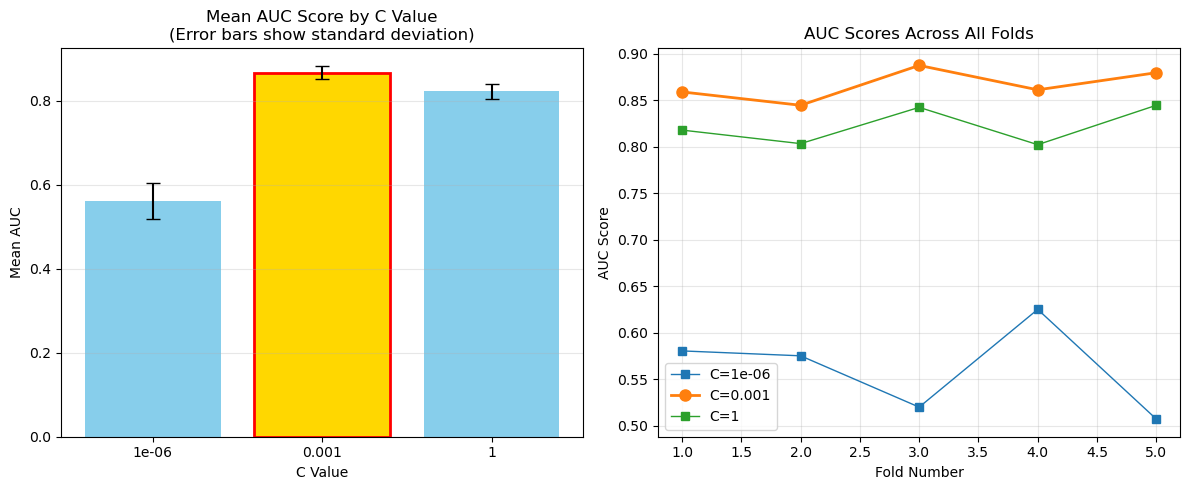

In [118]:
# Question 6: Hyperparameter Tuning using 5-Fold Cross-Validation

# Define the C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold with the same parameters as Question 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results for each C value
hyperparameter_results = {}

print("HYPERPARAMETER TUNING: Testing different C values")
print("=" * 60)

# Test each C value
for C in C_values:
    print(f"\nTesting C = {C}")
    print("-" * 30)
    
    auc_scores_c = []
    
    # Perform 5-fold cross-validation for current C value
    for fold, (train_index, val_index) in enumerate(kf.split(X_full_train), 1):
        
        # Split data for the current fold
        X_train_fold, X_val_fold = X_full_train.iloc[train_index], X_full_train.iloc[val_index]
        y_train_fold, y_val_fold = y_full_train.iloc[train_index], y_full_train.iloc[val_index]

        # Transform data for the current fold using DictVectorizer
        dv_fold = DictVectorizer(sparse=False)

        train_dict_fold = X_train_fold[categorical_features + numerical_features].to_dict(orient='records')
        X_train_fold_dv = dv_fold.fit_transform(train_dict_fold)

        val_dict_fold = X_val_fold[categorical_features + numerical_features].to_dict(orient='records')
        X_val_fold_dv = dv_fold.transform(val_dict_fold)

        # Initialize and train the Logistic Regression model with current C value
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold_dv, y_train_fold)

        # Predict probabilities on the validation data for the current fold
        y_pred_prob_val_fold = model_fold.predict_proba(X_val_fold_dv)[:, 1]

        # Calculate AUC for the current fold
        auc_fold = roc_auc_score(y_val_fold, y_pred_prob_val_fold)
        auc_scores_c.append(auc_fold)
        
        print(f"  Fold {fold}: AUC = {auc_fold:.4f}")
    
    # Calculate mean and std for current C value
    mean_auc_c = np.mean(auc_scores_c)
    std_auc_c = np.std(auc_scores_c)
    
    # Store results
    hyperparameter_results[C] = {
        'mean_auc': mean_auc_c,
        'std_auc': std_auc_c,
        'all_scores': auc_scores_c
    }
    
    print(f"  Mean AUC: {mean_auc_c:.3f}")
    print(f"  Std AUC: {std_auc_c:.3f}")

# Display comprehensive results
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 60)

# Create a summary table
print(f"{'C Value':<12} {'Mean AUC':<10} {'Std AUC':<10} {'All Fold Scores'}")
print("-" * 55)

best_c = None
best_mean_auc = -1

for C in C_values:
    mean_auc = hyperparameter_results[C]['mean_auc']
    std_auc = hyperparameter_results[C]['std_auc']
    scores = hyperparameter_results[C]['all_scores']
    
    # Format scores for display
    scores_str = [f"{score:.3f}" for score in scores]
    
    print(f"{C:<12} {mean_auc:<10.3f} {std_auc:<10.3f} {scores_str}")
    
    # Track best C value
    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_c = C

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"🏆 Best C value: {best_c}")
print(f"🎯 Best mean AUC: {best_mean_auc:.3f}")
print(f"📊 Standard deviation at best C: {hyperparameter_results[best_c]['std_auc']:.3f}")

# Bonus: Visualization of results
plt.figure(figsize=(12, 5))

# Plot 1: Mean AUC for each C value
plt.subplot(1, 2, 1)
c_labels = [str(c) for c in C_values]
mean_aucs = [hyperparameter_results[c]['mean_auc'] for c in C_values]
std_aucs = [hyperparameter_results[c]['std_auc'] for c in C_values]

bars = plt.bar(c_labels, mean_aucs, yerr=std_aucs, capsize=5, 
               color=['gold' if c == best_c else 'skyblue' for c in C_values])
plt.xlabel('C Value')
plt.ylabel('Mean AUC')
plt.title('Mean AUC Score by C Value\n(Error bars show standard deviation)')
plt.grid(True, alpha=0.3, axis='y')

# Highlight the best bar
for i, (c, bar) in enumerate(zip(C_values, bars)):
    if c == best_c:
        bar.set_edgecolor('red')
        bar.set_linewidth(2)

# Plot 2: All fold scores for each C value
plt.subplot(1, 2, 2)
for i, C in enumerate(C_values):
    scores = hyperparameter_results[C]['all_scores']
    folds = list(range(1, len(scores) + 1))
    
    marker = 'o' if C == best_c else 's'
    linewidth = 2 if C == best_c else 1
    markersize = 8 if C == best_c else 6
    
    plt.plot(folds, scores, marker=marker, label=f'C={C}', 
             linewidth=linewidth, markersize=markersize)

plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.title('AUC Scores Across All Folds')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()